In [58]:
import numpy as np
import pandas as pd
import qPAI_cINN_uncertainty_estimation.config as c
import matplotlib.pyplot as plt
import pathlib
from qPAI_cINN_uncertainty_estimation.viz import save_fig
from qPAI_cINN_uncertainty_estimation.data import prepare_dataloader

In [2]:
output_csv = c.output_dir / 'multiple_eval.csv'
df = pd.read_csv(output_csv)

In [3]:
print(df)

     Unnamed: 0                         name partitioned_eval  sparsity_eval  \
0             0        phantom_3_partitioned             part              3   
1             1        phantom_3_partitioned             part              5   
2             2        phantom_3_partitioned             part             10   
3             3        phantom_3_partitioned             part             25   
4             4        phantom_3_partitioned             part             40   
..          ...                          ...              ...            ...   
235         235  generic_flexi_unpartitioned           unpart              3   
236         236  generic_flexi_unpartitioned           unpart              5   
237         237  generic_flexi_unpartitioned           unpart             10   
238         238  generic_flexi_unpartitioned           unpart             25   
239         239  generic_flexi_unpartitioned           unpart             40   

     med_calib_err  calib_err_68  med_u

In [23]:
df_phantom = df[df.name.str.startswith('p')]
df_generic = df[df.name.str.startswith('g')]
df_melanin = df[df.name.str.startswith('m')]

In [92]:
df = pd.read_csv(output_csv)
df = df[df.name.str.startswith('p')]  # Phantom only
#df = df[~df.name.str.contains('flexi')]  # Non-flexi only
phantom_best_rows_part = []
for train in ['_partitioned', 'unpartitioned']:
    for eval_part in [['part'], ['unpart']]:
        for sparsity in [3, 5, 10, 25, 40]:
            row = df[(df.name.str.contains(train)) & (df.partitioned_eval.isin(eval_part)) & (df.sparsity_eval == sparsity)].sort_values(by='med_rel_err').head(1).to_dict()
            row = {key: [sub_val for sub_val in val.values()][0] for key, val in row.items()}
            phantom_best_rows_part.append(row)
df = pd.DataFrame(phantom_best_rows_part)
df['Training'] = df.name.str.split('_').str[2]
df['Evaluation'] = df.partitioned_eval
df['Sparsity'] = df.sparsity_eval
df = df.round(1)
df['Median relative error and IQR'] = df.med_rel_err.astype(str) + '% (' + df.iqr_lower.astype(str) + ', ' + df.iqr_upper.astype(str) + ')%'
df.pivot(index='Sparsity', columns=['Training', 'Evaluation'], values=['Median relative error and IQR'])

Median relative error and IQR                      \
Training                     partitioned                       
Evaluation                          part              unpart   
Sparsity                                                       
3                     15.2% (6.7, 37.6)%  22.5% (9.8, 52.8)%   
5                     11.2% (4.5, 30.9)%  16.1% (6.5, 38.9)%   
10                     3.6% (1.4, 15.3)%   8.9% (3.5, 26.3)%   
25                      1.6% (0.5, 6.2)%   3.0% (1.1, 13.0)%   
40                      1.6% (0.5, 6.7)%    1.6% (0.5, 7.6)%   

                                                    
Training         unpartitioned                      
Evaluation                part              unpart  
Sparsity                                            
3           18.1% (8.5, 40.7)%  19.3% (8.6, 44.2)%  
5           10.2% (3.9, 34.3)%  11.6% (4.1, 34.5)%  
10           4.4% (1.7, 17.0)%   6.6% (2.2, 21.9)%  
25            2.0% (0.7, 9.9)%    2.4% (0.8, 7.9)%  
40            1.4% (0.5, 5.7)%    1.3% (0.4, 5.2)%

In [40]:
df = pd.read_csv(output_csv)
df = df[df.name.str.startswith('p')]
best_rows_flexi = []
best_rows_specific = []

for sparsity in [3, 5, 10, 25, 40]:
    flexi_row = df[(df.name.str.contains('flexi')) & (df.sparsity_eval == sparsity)].sort_values(by='med_rel_err').head(1).to_dict()
    flexi_row = {key: [sub_val for sub_val in val.values()][0] for key, val in flexi_row.items()}
    specific_row = df[(~df.name.str.contains('flexi')) & (df.sparsity_eval == sparsity)].sort_values(by='med_rel_err').head(1).to_dict()
    specific_row = {key: [sub_val for sub_val in val.values()][0] for key, val in specific_row.items()}
    best_rows_flexi.append(flexi_row)
    best_rows_specific.append(specific_row)

flexi_df = pd.DataFrame(best_rows_flexi)
specific_df = pd.DataFrame(best_rows_specific)
flexi_df

,Unnamed: 0,name,partitioned_eval,sparsity_eval,med_calib_err,calib_err_68,med_uncert_68,med_rel_err,iqr_lower,iqr_upper
0,25,phantom_flexi_partitioned,part,3,0.145463,-0.190517,0.194850,17.655638,8.050552,42.894523
1,26,phantom_flexi_partitioned,part,5,0.122068,-0.173012,0.129850,12.033012,4.648305,32.419706
2,27,phantom_flexi_partitioned,part,10,0.014942,-0.030437,0.062855,3.636276,1.368840,15.336900
3,28,phantom_flexi_partitioned,part,25,0.060951,0.065965,0.039856,1.793022,0.609296,7.771667
4,29,phantom_flexi_partitioned,part,40,0.086030,0.090577,0.038707,1.557728,0.539810,6.713576


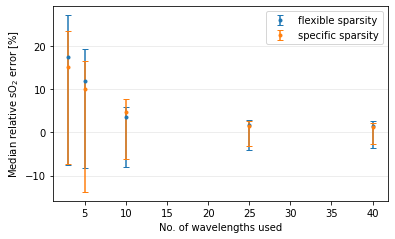

In [41]:

def get_relative_iqrs(name, df):
    return np.vstack((df["iqr_upper"] - df[name], df[name] - df["iqr_lower"]))

fig, ax = plt.subplots()
fig.subplots_adjust(top=0.8)
#ax.set_xlim(0, 100)
#ax.set_ylim(0, 100)
ax.set_ylabel(f"Median relative sO$_2$ error [%]")
ax.set_xlabel("No. of wavelengths used")
x = flexi_df['sparsity_eval']
y = flexi_df['med_rel_err']
#ax.plot(np.arange(0, 100), np.arange(0, 100), color='k', linestyle='-', linewidth=2, zorder=100)
ax.errorbar(
    x, y,
    yerr=get_relative_iqrs('med_rel_err', flexi_df),
    label='flexible sparsity',
    #elinewidth=0.1,
    capsize=3,
    #ecolor='r',
    #errorevery=10,
    #markevery=10,
    #ls='none',
    ms=3,
    fmt='o',
)

x = specific_df['sparsity_eval']
y = specific_df['med_rel_err']
ax.errorbar(
    x, y,
    yerr=get_relative_iqrs('med_rel_err', specific_df),
    label='specific sparsity',
    #elinewidth=0.1,
    capsize=3,
    #ecolor='r',
    #errorevery=10,
    #markevery=10,
    #ls='none',
    ms=3,
    fmt='o',
)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
ax.legend()
#ax.set_title(f"{measure_str} sO2 predictions of cINN based on 1000 samples")
#save_fig(c.output_dir, f"flexi_specific_generic.png")

In [48]:
training_dataloader = prepare_dataloader(c.data_path, 'FlowPhantom_insilico_complicated', 'training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))

[tensor([[0.9895, 0.9895]]),
 tensor([[0.8111, 0.8111]]),
 tensor([[0.6818, 0.6818]]),
 tensor([[0.4985, 0.4985]]),
 tensor([[0.4380, 0.4380]]),
 tensor([[0.8096, 0.8096]]),
 tensor([[0.8786, 0.8786]]),
 tensor([[0.1197, 0.1197]]),
 tensor([[0.2165, 0.2165]]),
 tensor([[0.4983, 0.4983]]),
 tensor([[0.6925, 0.6925]]),
 tensor([[0.6708, 0.6708]]),
 tensor([[0.3425, 0.3425]]),
 tensor([[0.9476, 0.9476]]),
 tensor([[0.7010, 0.7010]]),
 tensor([[0.0928, 0.0928]]),
 tensor([[0.8208, 0.8208]]),
 tensor([[0.3248, 0.3248]]),
 tensor([[0.7369, 0.7369]]),
 tensor([[0.7256, 0.7256]]),
 tensor([[0.0547, 0.0547]]),
 tensor([[0.9918, 0.9918]]),
 tensor([[0.0960, 0.0960]]),
 tensor([[0.6793, 0.6793]]),
 tensor([[0.7256, 0.7256]]),
 tensor([[0.4107, 0.4107]]),
 tensor([[0.5475, 0.5475]]),
 tensor([[0.9757, 0.9757]]),
 tensor([[0.5629, 0.5629]]),
 tensor([[0.5907, 0.5907]]),
 tensor([[0.3703, 0.3703]]),
 tensor([[0.8594, 0.8594]]),
 tensor([[0.5907, 0.5907]]),
 tensor([[0.1824, 0.1824]]),
 tensor([[0.30

(array([11836., 12994., 13779., 14979., 13216., 11522., 12729., 14103.,
        16680., 12786.]),
 array([0.00230804, 0.10197053, 0.20163302, 0.3012955 , 0.40095797,
        0.5006205 , 0.60028297, 0.69994545, 0.79960793, 0.8992704 ,
        0.9989329 ], dtype=float32),
 <BarContainer object of 10 artists>)

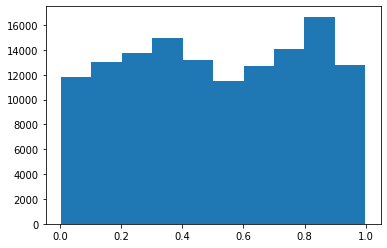

In [54]:
plt.hist(labels)

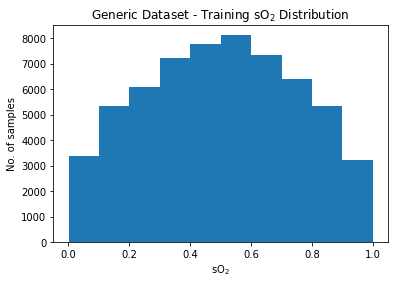

In [66]:
training_dataloader = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'NoSkin_filtered', 'filtered_training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))
fig, ax = plt.subplots()
ax.hist(labels)
ax.set_xlabel('sO$_2$')
ax.set_ylabel('No. of samples')
ax.set_title('Generic Dataset - Training sO$_2$ Distribution')
plt.show()

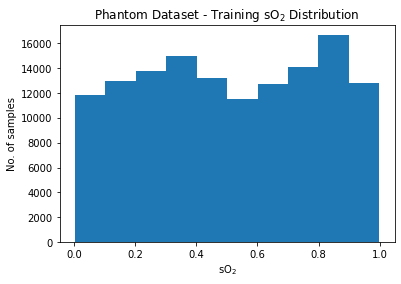

In [65]:
training_dataloader = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'FlowPhantom_insilico_complicated', 'training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))
fig, ax = plt.subplots()
ax.hist(labels)
ax.set_xlabel('sO$_2$')
ax.set_ylabel('No. of samples')
ax.set_title('Phantom Dataset - Training sO$_2$ Distribution')
plt.show()

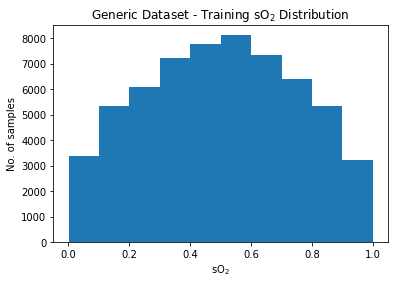

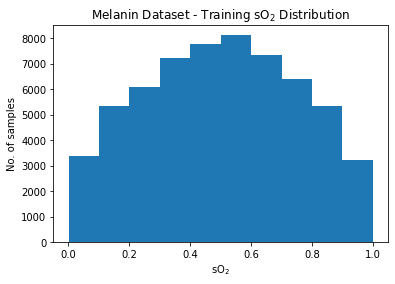

In [68]:
training_dataloader = prepare_dataloader(pathlib.Path(r'I:\research\seblab\data\group_folders\Kevin\PartIII_Kevin_Gu\Datasets'), 'NoSkin_filtered', 'filtered_training', [40], 1)
labels = []
for data, label in iter(training_dataloader):
    labels.append(np.array(label[0][0]))
fig, ax = plt.subplots()
ax.hist(labels)
ax.set_xlabel('sO$_2$')
ax.set_ylabel('No. of samples')
ax.set_title('Melanin Dataset - Training sO$_2$ Distribution')
plt.show()